In [ ]:
#pip install transformers==4.45.2 sentence-transformers==3.1.1 datasets evaluate

In [ ]:
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from peft import PeftModel, LoraConfig, get_peft_model
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

model_id = "distilbert/distilbert-base-uncased"
id2label = {0: "No-Success", 1: "Success"}
label2id = {"No-Success": 0, "Success": 1}

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id, add_prefix_space=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2, id2label=id2label, label2id=label2id
)

# Load and preprocess data
companies = pd.read_csv('companies_fe.csv')
companies['Success'] = (
    (companies['Was Acquired'] == 1) |
     (companies['IPO'] == 1) |
      (companies['HighFunding'] == 1)
      ).astype(int)

excluded_cols = ['Was Acquired', 'IPO', 'HighFunding', 'Success', 'Description', 'LinkedIn', 'Twitter', 'ID', 'Website',
                 'Project Funding', 'Startup Funding', 'Growth Funding', 'Expansion Funding', 'Exit Funding', 'Company ID', 'Facebook']
random_pairs = []
num_combinations = 10

# Generate input-output pairs
for _, row in companies.iterrows():
    eligible_cols = [col for col in companies.columns if col not in excluded_cols]
    for _ in range(num_combinations):
        selected = random.sample(eligible_cols, min(len(eligible_cols), 5))
        details = [f"{col}: {row[col]}" for col in selected if pd.notna(row[col])]
        input_text = "Company Details: " + "; ".join(details) + ". Predict Success"
        random_pairs.append({"text": input_text.replace("\n", ""), "label": int(row['Success'])})

random_pairs = pd.DataFrame(random_pairs)
train, test = train_test_split(random_pairs,
                               test_size=0.4,
                               stratify=random_pairs["label"])

# Balance the training dataset
oversampler = RandomOverSampler(sampling_strategy='minority')
train_balanced, labels_balanced = oversampler.fit_resample(train, train['label'])

train = Dataset.from_pandas(train_balanced)
test = Dataset.from_pandas(test)


# Tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    tokenizer.pad_token = '[PAD]'
    model.resize_token_embeddings(len(tokenizer))

model.config.pad_token_id = tokenizer.pad_token_id

tokenized_train_dataset = train.map(tokenize_function, batched=True)
tokenized_test_dataset = test.map(tokenize_function, batched=True)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    precision = precision_score(labels, predictions, pos_label=1)

    recall = recall_score(labels, predictions, pos_label=1)

    f1 = f1_score(labels, predictions, pos_label=1)

    return {"precision": precision, "recall": recall, "f1": f1}

# PEFT configuration
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=16,
    lora_alpha=32,
    lora_dropout=0.2,
    target_modules=['q_lin']
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Training arguments
training_args = TrainingArguments(
    output_dir=model_id + "-lora-text-classification",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

# Custom trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        inputs = {k: v for k, v in inputs.items() if k not in ['num_items_in_batch']}
        outputs = model(**inputs)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate and adjust threshold
raw_predictions = trainer.predict(tokenized_test_dataset)
y_probs = torch.nn.functional.softmax(torch.tensor(raw_predictions.predictions), dim=1)[:, 1].numpy()
labels = raw_predictions.label_ids
precision, recall, thresholds = precision_recall_curve(labels, y_probs)
optimal_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall))]
predictions = (y_probs > optimal_threshold).astype(int)



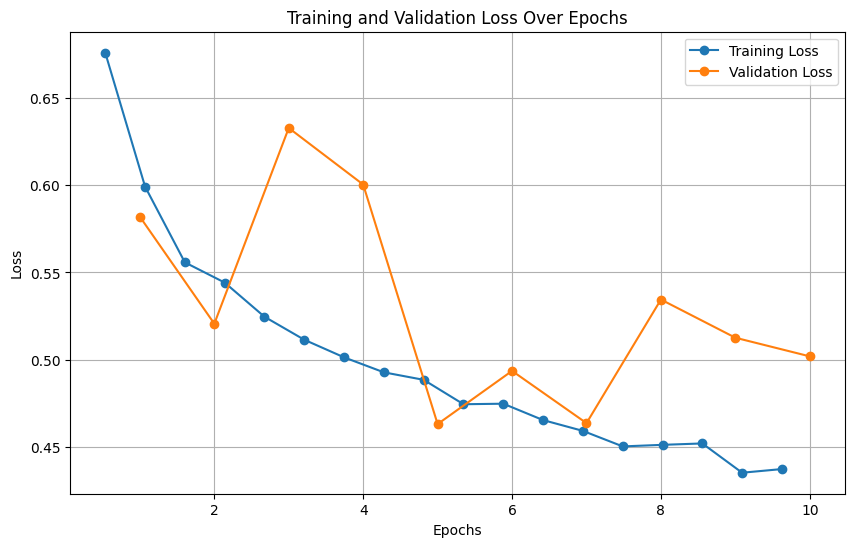

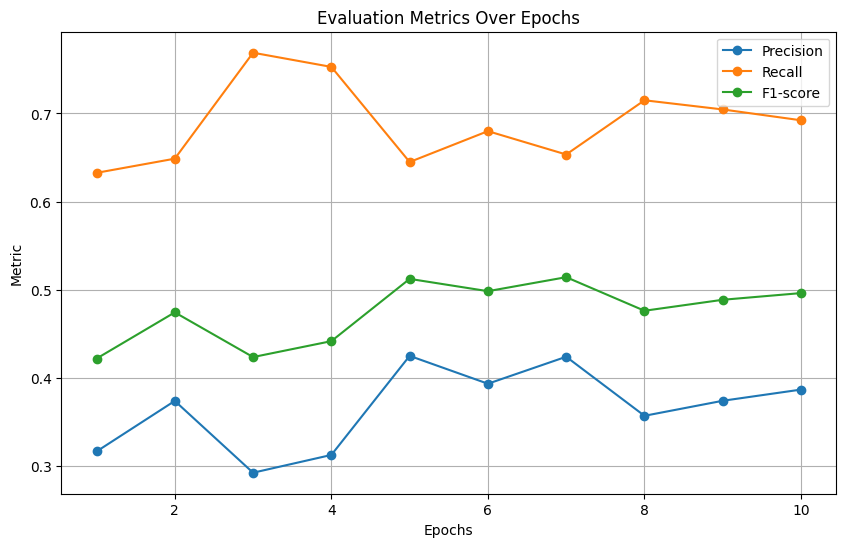

In [8]:
# Visualize training process
log_history = trainer.state.log_history

# Separate training and validation loss and metrics
train_epochs = []
eval_epochs = []
train_loss = []
eval_loss = []
precision_scores = []
recall_scores = []
f1_scores = []

for log in log_history:
    if 'loss' in log and 'epoch' in log:  # Training loss
        train_epochs.append(log['epoch'])
        train_loss.append(log['loss'])
    if 'eval_loss' in log:  # Validation loss
        eval_epochs.append(log['epoch'])
        eval_loss.append(log['eval_loss'])
    if 'eval_precision' in log:  # Precision
        precision_scores.append(log['eval_precision'])
    if 'eval_recall' in log:  # Recall
        recall_scores.append(log['eval_recall'])
    if 'eval_f1' in log:  # F1-score
        f1_scores.append(log['eval_f1'])

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_loss, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Evaluation Metrics
plt.figure(figsize=(10, 6))
plt.plot(eval_epochs, precision_scores, label="Precision", marker="o")
plt.plot(eval_epochs, recall_scores, label="Recall", marker="o")
plt.plot(eval_epochs, f1_scores, label="F1-score", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Metric")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

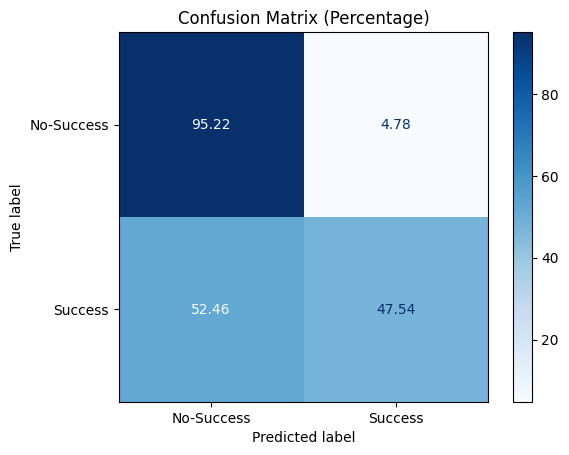

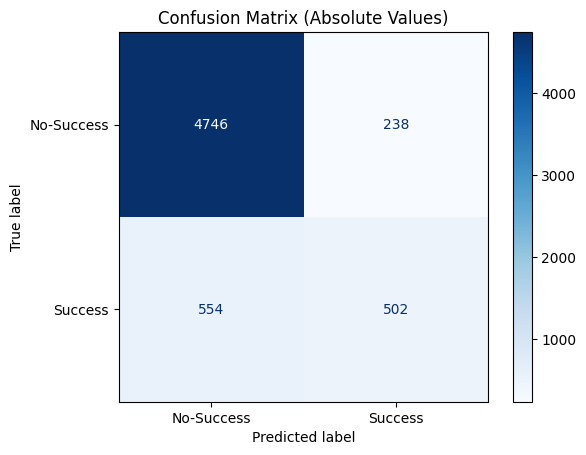

In [7]:
# Confusion matrix
cm = confusion_matrix(labels, predictions, labels=[0, 1])
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cmd = ConfusionMatrixDisplay(cm_percentage, display_labels=["No-Success", "Success"])
cmd.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Absolute Confusion Matrix
cmd_abs = ConfusionMatrixDisplay(cm, display_labels=["No-Success", "Success"])
cmd_abs.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix (Absolute Values)")
plt.show()
